In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import imageio
from scipy.stats import beta

# Apresentação de papers (Analytics Produtos e CRM): Carlo 06/03/2020

Essa apresentação é fortemente inspirada no post [Introduction to Thompson Sampling: the Bernoulli bandit](https://gdmarmerola.github.io/ts-for-bernoulli-bandit/) do blog do Guilherme Marmerola.

Suponha que você entre em um cassino e resolva jogar nas $K$ máquinas de caça-níqueis disponíveis. Assuma que o custo para jogar em cada uma e a recompensa por vencer nelas sejam iguais. Como o resultado é sucesso (você ganha) ou fracasso (você perder), a distribuição que determina se você vai ganhar ou não em uma máquina $k$ ($1\leq k \leq K$) é $\textrm{Ber}(\theta_k)$, com $\theta_k \in [0,1]$ constante no tempo.

Você, apostador, se depara com as máquinas sem saber qual é a que te dá mais chance de vencer (ou seja, você não conhece os parâmetros $\theta_k$). Para encontrá-la devemos balancear nosso apetite pela exploração das máquinas que se mostraram melhores no passado e pela experimentação de máquinas que possivelmente podem ser melhores.

<img src="bandido.jpg">

Vamos simular a situação em que nos encontramos com $K$=4 bandidos com diferentes parâmetros definidos abaixo. Discutiremos algumas abordagens simples de políticas possíveis para balancear a experimentação e a exploração.

In [2]:
bandidos_parametros = [0.3, 0.15, 0.4, 0.35]

## Política de Seleção aleatória

Descartando a ideia da exploração (escolher a máquina que foi melhor no passado), podemos fazer a mais pura experimentação. Jogando aleatoriamente entre todas as máquinas por um período específico, conseguimos calcular, utilizando um estimador de máxima verossimelhaça, o parâmetro $\theta_k$ das Bernoullis!

O política segue a regra dada como:
* Em um primeiro momento (primeiras `tempo_treinamento` rodadas), que estou chamando de treino, esse algoritmo faz apenas a exploração:
    * Sorteia-se um $k \in [1, K] \cap \mathbb{Z}$ uniformemente.
    * Joga-se na máquina $k$.


* Após esse primeiro momento, estima-se os parâmetros

$$\hat{\theta}_k = \frac{\textrm{(número de vezes que vencemos jogando em }k)}{(\textrm{número de jogadas totais em }k)}.$$

In [3]:
from bom_dia import politica_aleatoria

tempo_treinamento = 200
politica_random = politica_aleatoria(bandidos_parametros)
politica_random.train(tempo_treinamento)

A linha abaixo cria um gif (e as imagens do gif) na pasta associada à essa política mostrando a dinâmica do jogo.

In [4]:
from bom_dia import gerando_gif

gerando_gif(politica_random, bandidos_parametros)

Pela Lei Forte dos Grandes Números (para Bernoullis), os parâmetros $\hat{\theta}_k$ convergem quase-certamente (isto é, com probabilidade 1) para o verdadeiro $\theta_k$ quando o $({\textrm{número de jogadas totais em }k})$ cresce, mas isso pode demorar muito mais que o desejado.

Quando o custo de cada jogada é muito baixo, essa estratégia pode ser útil, mas, no geral, buscamos políticas que durante o experimento já aprendam com os acertos e erros das jogadas passadas.

## Estratégia $\varepsilon$-greedy

Tentando acrescentar um pouco de exploração à nossa aleatoriedade na experimentação, em uma rodada $n$, surge a ideia de jogar no bandido que foi melhor até agora. Para isso, escolhemos 
$$ k =  {\arg\max}_{1\leq t \leq K} \,\,\,\hat{\theta}_t(n),$$
em que 
$$\hat{\theta}_k(n) = \frac{\textrm{(número de vezes que vencemos jogando em }k \textrm{ até a rodada }n)}{(\textrm{número de jogadas totais em }k \textrm{ até a rodada }n)}.$$

Mas imagine o cenário em que jogando 1 vezes em cada uma das máquinas, apenas na máquina 1 ganhamos e em todas as outras perdemos. Neste caso, $\hat{\theta}_1(K) = 1$ e $\hat{\theta}_k(K) = 0 $ para $1<k\leq K$. A nossa proxíma jogada seria na máquina 1, e independente de quantas vezes perdessemos nela, escolheríamos para sempre a máquina 1 pois $\hat{\theta}_1(n)>0=\hat{\theta}_k(n)$ para $1<k\leq K$ e $n\geq K$.

Para amenizar isso, com probabilidade $1 - \varepsilon$ jogamos na máquina que teve a melhor taxa de vitórias até agora, e como probabilidade $\varepsilon$ escolhemos uma máquina qualquer aleatoriamente, como na política aleatória.

O política segue a regra dada como:
* Em um primeiro momento (primeiras `tempo_treinamento` rodadas), que estou chamando de treino, esse algoritmo faz apenas a exploração:
    * Defina $\hat{\theta}_k(0) = 0.5$ para $1\leq k \leq K$.
    * No início da rodada $n$ sorteamos um número de uma distribuição $\textrm{Ber}(1-\varepsilon)$. Se o número sorteado for 1, então $ k = \arg \max \hat{\theta}_t(n)$. Se o número sorteado for zero então sorteia-se um $k \in [1, K] \cap \mathbb{Z}$ uniformemente.
    * Joga-se na máquina $k$.


* Após esse primeiro momento, estima-se os parâmetros

$$\hat{\theta}_k = \frac{\textrm{(número de vezes que vencemos jogando em }k)}{(\textrm{número de jogadas totais em }k)}.$$

In [5]:
from bom_dia import politica_epsilon_greedy

politica_eps = politica_epsilon_greedy(bandidos_parametros)
politica_eps.train(tempo_treinamento)

A linha abaixo cria um gif (e as imagens do gif) na pasta associada à essa política mostrando a dinâmica do jogo.

In [6]:
gerando_gif(politica_eps, bandidos_parametros, epsilon_greedy=True)

Entre os problemas dessa técnica, está a adição de um hiper-parâmetro $\varepsilon$ e sua otimização não é trivial: se o $\varepsilon$ é muito grande, então podemos estar fazendo muita exploração aleatória e perdendo oportunidade de exploração; se o $\varepsilon$ é muito pequeno podemos estar presos por muito tempo em máquinas subótimas sem muito espaço para explorar e aperfeiçoar nosso conhecimento sobre os outros bandidos.

A ideia é ter $\varepsilon$ grande no início para melhor exploração e um $\varepsilon$ pequeno no final para explorar os recursos do bandido que a gente mais confia.

## Estratégia $\varepsilon$-decreasing

A ideia aqui é justamente adaptar o tamanho do $\varepsilon$ de acordo com o momento da exploração. Neste caso, a probabilidade de escolher uma máquina ao acaso na jogada $n$ é dada por uma função decrescente $\varepsilon(n)$. Para fins de ilustração, fiz $\varepsilon(n)$ na forma:

$$ \varepsilon(n) = \varepsilon_0 \left( 1 - \frac{n}{\textrm{tempo total de treinamento}} \right).$$


In [7]:
politica_eps = politica_epsilon_greedy(bandidos_parametros)
politica_eps.train(tempo_treinamento, decreasing = True)

A linha abaixo cria um gif (e as imagens do gif) na pasta associada à essa política mostrando a dinâmica do jogo.

In [8]:
gerando_gif(politica_eps, bandidos_parametros, epsilon_greedy = True)

## Distribuição $\textrm{Beta}$

A distribuição Beta é uma boa forma de estimar o parâmetro $\theta_k$ da Bernoulli a partir do número de vitórias e derrotas que tivemos ao jogar na máquina $k$. Se, ao jogar contra o robô $k$, tivemos $\alpha_k$ vitórias e $\beta_k$ derrotas, então podemos usar $\textrm{Beta}(1+\alpha_k,1+\beta_k)$ para nos dar informação sobre $\theta_k$.

/home/carlo/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


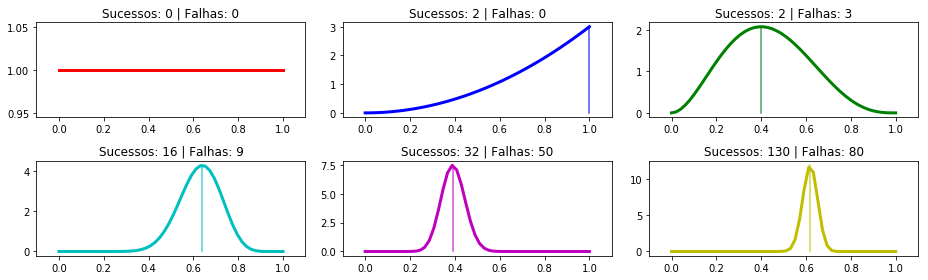

In [9]:
from bom_dia import exemplos_beta

exemplos_beta()

A interpretação é que, no início (em vermelho), não temos informações sobre como é $\theta_k$ e por isso usamos uma distribuição uniforme para esse parâmetro. Essa é a distribuição a priori para o parâmetro do bandido.

Conforme jogamos (em azul) e temos resultados positivos, a distribuição da densidade de probabilidade se desloca para a direita e acreditamos ter um parâmetro alto já que temos evidência para crer nisso. Essa agora é a nossa distribuição a posteriori, estamos adaptando a distribuição de acordo com os dados que já vimos. 

Isso vai se adaptando coforme jogamos e ganhamos novas evidências. Durante esse processo, nossa variável vai se concentrando em algum valor.

Uma coisa interessante é que o máximo da densidade de probabilidade de uma variável aleatória com distribuição 

$$\textrm{Beta}(1+(\textrm{(número de vezes que vencemos jogando em }k), 1 +(\textrm{(número de vezes que perdemos jogando em }k))$$

está em 

$$\frac{\textrm{(número de vezes que vencemos jogando em }k)}{(\textrm{número de jogadas totais em }k)},$$

o valor de máxima verossimelhança para parâmetro do nossa máquina $k$.

## Thompson Sampling

O política segue a regra dada como:

* No início da rodada $n$, para cada máquina $k$, $1\leq k \leq K$, sorteamos um número $\theta_k^\dagger$ de uma distribuição 

$$\textrm{Beta}(1+(\textrm{(número de vezes que vencemos jogando em }k \textrm{ até a rodada }n), 1 +(\textrm{(número de vezes que perdemos jogando em }k \textrm{ até a rodada }n))$$

* Escolha o valor de $k$ que tem melhor parâmetro da Bernoulli estimado $\theta_k^\dagger$, isto é,

$$ k =  {\arg\max}_{1\leq t \leq K} \,\,\,\theta_t^\dagger(n),$$

* Joga-se na máquina $k$.


In [10]:
from bom_dia import politica_thompson

politica_thomp = politica_thompson(bandidos_parametros)
politica_thomp.train(tempo_treinamento)

A linha abaixo cria um gif (e as imagens do gif) na pasta associada à essa política mostrando a dinâmica do jogo.

In [11]:
gerando_gif(politica_thomp, bandidos_parametros, thompson= True)